In [1]:
import tensorflow as tf
import optuna
import shap
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.optimizers.legacy import RMSprop

In [2]:
df = pd.read_csv('prepared_LOB_trunc_data.csv',
                 index_col=0) # if this file is read, you could start from cell number 17
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_ask_prices_1,time_bid_prices_2,time_ask_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
999,2023-10-02 00:00:06.051655936,27993.64,27996.08,0.072713,0.188,27993.41,27996.38,0.150000,0.060000,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1000,2023-10-02 00:00:06.051817984,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1001,2023-10-02 00:00:06.051911168,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105386
1002,2023-10-02 00:00:06.051913984,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065679
1003,2023-10-02 00:00:06.052875008,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020,27968.26,27970.25,0.020000,0.053564,27967.98,...,0,1,0,1,0,1,0,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790948


In [3]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    if 'bid' in column:
      repr_column = 'ask_prices_0'
    else:
      repr_column = 'bid_prices_0'
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[repr_column]>num][repr_column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
    return time

In [4]:
columns = ['bid_prices_0', 'ask_prices_0', 'bid_prices_1','ask_prices_1', 'bid_prices_2', 'ask_prices_2', 
           'bid_prices_3', 'ask_prices_3', 'bid_prices_4', 'ask_prices_4']

In [ ]:
for column in columns:
  df['time_'+column] = finder_of_fulfilment(df, column)

In [ ]:
for column in columns:
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),4)

In [ ]:
def plot_KM_estimator(column):
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df[df['time_'+column]==time])
      num_survived = len(df[df['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)


  S_hat = np.cumprod(S_of_t)
  return S_hat, times

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for column in columns:
  KM_est, times = plot_KM_estimator(column)
  if 'bid' in column:
    ax1.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]}, 
             {column.split('_')[0]} pegged")
    ax1.set_xlabel('t (sec.)')
    ax1.set_ylabel('$\hat{S}(t)$')
    ax1.set_title('Bid Survival Probability Over Time')
    ax1.legend()
    ax1.grid(True)

  else:
    ax2.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]},
             {column.split('_')[0]} pegged")
    ax2.set_xlabel('t (sec.)')
    ax2.set_ylabel('$\hat{S}(t)$')
    ax2.set_title('Ask Survival Probability Over Time')
    ax2.legend()
    ax2.grid(True)

plt.show()

In [ ]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

In [ ]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

In [ ]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

In [ ]:
threshold=1
for column in columns:
  df['time_' + column] = df['time_' + column].apply(lambda x: 1 if x < threshold else 0)

In [ ]:
df.dropna(inplace=True)
df.describe()

In [ ]:
df.to_csv('prepared_LOB_trunc_data.csv')

In [5]:
columns_to_drop = ['time_' + col for col in columns] + ['timestamp']

features_to_transform = [element for element in df.columns if element 
                         not in columns_to_drop+['vol_imbalance','daily_volatility']]
df[features_to_transform] = df[features_to_transform].diff()

In [6]:
# Do some work with features:
df.dropna(inplace=True)

In [7]:
N = 100  # Define the number of previous observations included

X = df.drop(columns=columns_to_drop).iloc[:len(df)]
Y = df[['time_' + col for col in columns if 'ask_prices_0' in col]].iloc[N:len(df)].values

print(Y.shape)

(101986, 1)


In [8]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

X.shape

2024-01-06 17:53:07.779599: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-06 17:53:07.779682: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-06 17:53:07.779715: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-06 17:53:07.779821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-06 17:53:07.779876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([101986, 101, 23])

,time_ask_prices_0,time_ask_prices_1,time_ask_prices_2,time_ask_prices_3,time_ask_prices_4
count,101986.000000,101986.000000,101986.000000,101986.000000,101986.000000
mean,0.287912,0.212980,0.170572,0.136901,0.116751
std,0.452792,0.409416,0.376137,0.343745,0.321125
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


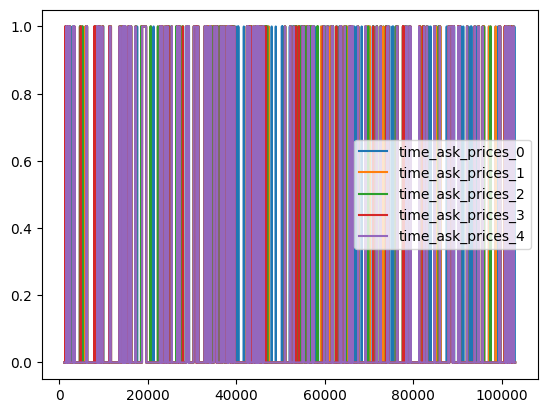

In [9]:
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)].plot()
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)].describe()

In [10]:
print('X shape :', X.shape)
print('Y shape :',Y.shape[0])

X shape : (101986, 101, 23)
Y shape : 101986


In [11]:
X_np = X.numpy()

# Now use train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y, test_size=0.8,
                                                    shuffle=True) # just to make test training
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

In [12]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train.ravel()),  # Ensure Y_train is 1-dimensional
    y=Y_train.ravel()                    # Ensure Y_train is 1-dimensional
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.6973484272906854, 1: 1.7667949951876805}

In [13]:
bias_initializer =  -np.log(np.count_nonzero(Y_train)/(len(Y_train)-np.count_nonzero(Y_train)))
bias_initializer

0.9296372654827367

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, filters, kernel_size_Q, kernel_size_K, kernel_size_V, units,
                 dilation_rate, num_heads, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.dilation_rate = dilation_rate

        # Define Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Define Dilated Convolution layers for Q, K, V
        self.dilated_conv_Q1 = self._create_conv_block(filters, kernel_size_Q)
        self.dilated_conv_K1 = self._create_conv_block(filters, kernel_size_K)
        self.dilated_conv_V1 = self._create_conv_block(filters, kernel_size_V)

        # Global Average Pooling layer
        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

        # Multi-Head Attention layer with Layer Normalization
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=units)
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-4)

    def _create_conv_block(self, filters, kernel_size):
        """Helper function to create a convolutional block."""
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                   dilation_rate=self.dilation_rate, padding='same', 
                                   activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            self.dropout
        ])

    def call(self, inputs):
        # Apply convolutional block to Q, K, V
        Q = self.dilated_conv_Q1(inputs)
        Q = self.global_avg_pooling(Q)
        Q = tf.expand_dims(Q, axis=1)  # Reshape for attention layer

        K = self.dilated_conv_K1(inputs)
        K = self.global_avg_pooling(K)
        K = tf.expand_dims(K, axis=1)  # Reshape for attention layer

        V = self.dilated_conv_V1(inputs)
        V = self.global_avg_pooling(V)
        V = tf.expand_dims(V, axis=1)  # Reshape for attention layer

        # Multi-Head Attention with Layer Normalization
        attention_output = self.multi_head_attention(Q, K, V)
        attention_output = self.attention_norm(attention_output)

        return attention_output

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, units, num_dense_layers=20, dropout_rate=0.1):
        super(Decoder, self).__init__()

        # Flatten layer
        self.flatten = tf.keras.layers.Flatten()

        # Dense layers with batch normalization and dropout
        self.dense_layers = []
        for _ in range(num_dense_layers):
            self.dense_layers.append(tf.keras.Sequential([
                tf.keras.layers.Dense(units=units, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(dropout_rate)
            ]))

        # Self-Attention layers
        self.attention_layers = [SeqSelfAttention(units=i, attention_activation='relu', 
                                                  attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL) 
                                 for i in range(5)]

    def call(self, x):
        x = self.flatten(x)
        x = tf.expand_dims(x, -1)

        # Apply dense layers with residual connections
        for i, layer in enumerate(self.dense_layers):
            original_x = x
            x = layer(x)
            if (i + 1) % 2 == 0:  # Apply residual connection every 2 layers
                x = x + original_x  # Add the input x to the output of two dense layers

        # Apply attention layers
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return x

In [16]:
def create_full_model(input_shape, filters, num_heads, units, 
                      kernel_size_Q, kernel_size_K, kernel_size_V, dilation_rate):
    # Reshape the input to add a channel dimension
    encoder_inputs = layers.Input(shape=input_shape)
    reshaped_inputs = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(encoder_inputs)

    # Create an instance of the Encoder
    encoder = Encoder(filters=filters, kernel_size_Q=kernel_size_Q, kernel_size_K=kernel_size_K, 
                      kernel_size_V=kernel_size_V, units=units, dilation_rate=dilation_rate, num_heads=num_heads)

    # Get the output from the encoder
    encoder_output = encoder(reshaped_inputs)

    # Create an instance of the Decoder
    decoder = Decoder(units=units*2)

    # Get the output from the decoder
    decoder_output = decoder(encoder_output)

    # Flatten and final layers
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(flat_output)

    # Create the model
    model = tf.keras.Model(inputs=encoder_inputs, outputs=output)
    return model

In [17]:
print(X_train.shape, Y_train.shape)

(18357, 101, 23) (18357, 1)


In [20]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = 1
filters = 32
units = 128
kernel_size_Q, kernel_size_K, kernel_size_V = 4,4,4
num_heads = 32
d_model = 2
batch = 8
dilation_rate = 4

In [21]:
# Create the model
model = create_full_model(input_shape, filters, num_heads, units, 
                          kernel_size_Q, kernel_size_K, kernel_size_V, dilation_rate)
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Train the model with a validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(x=X_train, y=Y_train,
          batch_size=batch,
          epochs=100,
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_val, Y_val))

Epoch 1/100


2024-01-06 17:54:11.027231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2295/2295 [==============================] - 883s 345ms/step - loss: 2.4413 - accuracy: 1.0000 - precision: 0.2839 - recall: 0.4839 - auc: 0.5055 - val_loss: 5.5958 - val_accuracy: 1.0000 - val_precision: 0.2642 - val_recall: 0.8915 - val_auc: 0.4596
Epoch 2/100
2295/2295 [==============================] - 744s 324ms/step - loss: 1.9844 - accuracy: 1.0000 - precision: 0.2854 - recall: 0.4961 - auc: 0.5021 - val_loss: 1.3670 - val_accuracy: 1.0000 - val_precision: 0.1937 - val_recall: 0.0561 - val_auc: 0.4645
Epoch 3/100
2295/2295 [==============================] - 749s 326ms/step - loss: 1.4032 - accuracy: 1.0000 - precision: 0.2864 - recall: 0.4939 - auc: 0.5021 - val_loss: 2.9721 - val_accuracy: 1.0000 - val_precision: 0.2766 - val_recall: 0.9078 - val_auc: 0.5162
Epoch 4/100
2295/2295 [==============================] - 748s 326ms/step - loss: 1.1046 - accuracy: 1.0000 - precision: 0.2921 - recall: 0.5045 - auc: 0.5134 - val_loss: 0.6800 - val_accuracy: 1.0000 - val_precision: 0.1667

# Loss is pretty low but the model's perf is not so good. The size of the trainning set is small and it affects the perf but there is still no consistent learning.

In [22]:
Y_pred = model.predict(X_test)

2550/2550 [==============================] - 162s 58ms/step


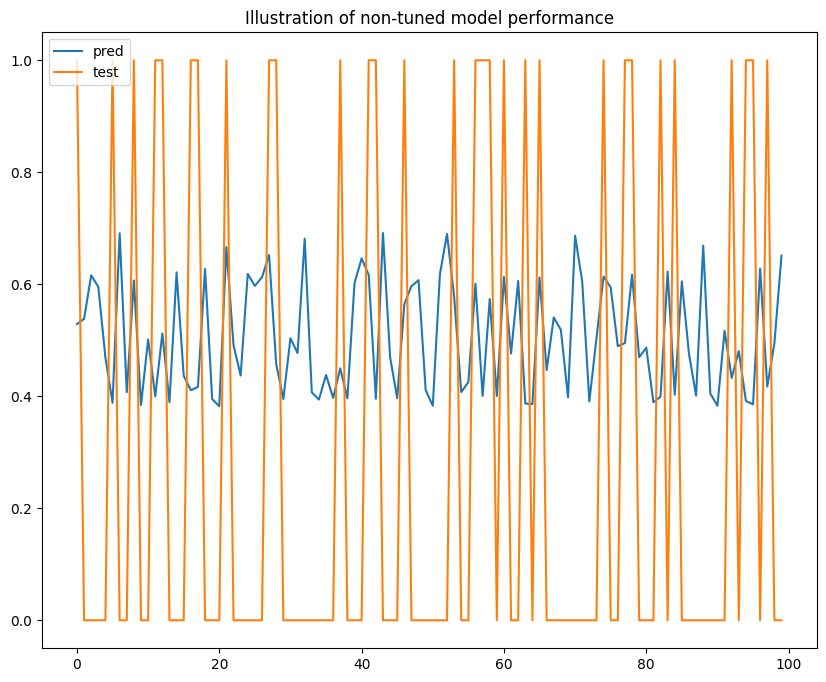

In [26]:
plt.figure(figsize=(10,8))
plt.title('Illustration of non-tuned model performance')
plt.plot(Y_pred[:100], label='pred')
plt.plot(Y_test[:100], label='test')
plt.legend()
plt.show()

# Training Visualization (could be skipped)

In [ ]:
optimizer = RMSprop(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, gradients

def plot_distribution(data, title):
    plt.hist(data.flatten(), bins=50)
    plt.title(title)
    plt.show()

# Assuming X and Y are your data and labels
for epoch in range(3):
    for step in range(0, len(X_train), batch):
        x_batch = X_train[step:step + batch]
        y_batch = Y_train[step:step + batch]

        loss, gradients = train_step(model, x_batch, y_batch)

        # Every N steps, visualize weights, activations, and gradients
        if step % 100 == 0:
            # Visualize weights and gradients
            for var, grad in zip(model.trainable_variables, gradients):
                plot_distribution(var.numpy(), f'Weights of {var.name}')
                plot_distribution(grad.numpy(), f'Gradients of {var.name}')

            # Visualize activations
            intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for 
                                                                             layer in model.layers])
            activations = intermediate_model.predict(x_batch)
            for i, activation in enumerate(activations):
                plot_distribution(activation, f'Activation of layer {i+1}')

# Adjusting Hyperparametes

In [27]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])
    filters = trial.suggest_categorical('filters', [16, 32])
    units = trial.suggest_categorical('units', [64, 128])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [64, 128])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [3, 9])
    dilation_rate = trial.suggest_categorical('dilation_rate', [2, 3, 16])
    batch = trial.suggest_categorical('batch', [16,64])

    # Create the model
    model = create_full_model(input_shape, filters, num_heads, units, 
                              kernel_size_Q, kernel_size_K, kernel_size_V, dilation_rate)
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[#tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc')])
    
    print(filters, num_heads, d_model, units, kernel_size_Q, kernel_size_K, kernel_size_V)
    
    # Train the model with a validation set
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    
    history = model.fit(x=X_train, y=Y_train, 
              batch_size=batch, 
              epochs=10, 
              callbacks=[callback],
              class_weight=class_weights_dict,
              validation_data=(X_val, Y_val)) # Include validation data here

    val_loss = np.mean(history.history['val_auc']) + np.mean(history.history['auc'])
    
    return val_loss

# Optuna study
study = optuna.create_study(direction='maximize')  # 'minimize' if lower is better, 'maximize' otherwise
study.optimize(objective, n_trials=10)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-01-06 21:20:38,234] A new study created in memory with name: no-name-9c364dda-3873-418a-a96b-3c0326ef9df0


16 4 2 64 128 4 9
Epoch 1/10
1148/1148 [==============================] - 1501s 1s/step - loss: 0.9425 - precision: 0.2832 - recall: 0.4974 - auc: 0.5032 - val_loss: 0.8451 - val_precision: 0.2833 - val_recall: 0.7920 - val_auc: 0.5143
Epoch 2/10
1148/1148 [==============================] - 2055s 2s/step - loss: 0.8889 - precision: 0.2857 - recall: 0.4993 - auc: 0.5038 - val_loss: 0.9742 - val_precision: 0.2351 - val_recall: 0.4430 - val_auc: 0.4665
Epoch 3/10
1148/1148 [==============================] - 1286s 1s/step - loss: 0.8831 - precision: 0.2839 - recall: 0.4910 - auc: 0.5021 - val_loss: 0.6744 - val_precision: 0.3393 - val_recall: 0.1374 - val_auc: 0.4911
Epoch 4/10
1148/1148 [==============================] - 6854s 6s/step - loss: 0.8911 - precision: 0.2928 - recall: 0.5038 - auc: 0.5114 - val_loss: 0.6317 - val_precision: 0.2838 - val_recall: 0.1139 - val_auc: 0.5349
Epoch 5/10
1148/1148 [==============================] - 3134s 3s/step - loss: 0.8714 - precision: 0.2867 - rec

[I 2024-01-07 03:26:21,163] Trial 0 finished with value: 1.0128792275985083 and parameters: {'num_heads': 4, 'filters': 16, 'units': 64, 'kernel_size_Q': 128, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 16, 'batch': 16}. Best is trial 0 with value: 1.0128792275985083.


32 8 2 128 128 4 9
Epoch 1/10
1148/1148 [==============================] - 3661s 1s/step - loss: 2.0672 - precision: 0.2842 - recall: 0.4955 - auc: 0.5040 - val_loss: 4.9605 - val_precision: 0.2555 - val_recall: 0.7324 - val_auc: 0.4657
Epoch 2/10
1148/1148 [==============================] - 759s 661ms/step - loss: 1.8164 - precision: 0.2845 - recall: 0.4907 - auc: 0.5023 - val_loss: 1.6852 - val_precision: 0.2681 - val_recall: 0.7685 - val_auc: 0.5056
Epoch 3/10
1148/1148 [==============================] - 1234s 1s/step - loss: 1.6020 - precision: 0.2947 - recall: 0.5082 - auc: 0.5213 - val_loss: 2.5344 - val_precision: 0.2628 - val_recall: 0.9277 - val_auc: 0.5107
Epoch 4/10
1148/1148 [==============================] - 1549s 1s/step - loss: 1.5817 - precision: 0.2828 - recall: 0.4914 - auc: 0.5029 - val_loss: 0.7241 - val_precision: 0.3755 - val_recall: 0.3327 - val_auc: 0.5839
Epoch 5/10
1148/1148 [==============================] - 761s 663ms/step - loss: 1.4495 - precision: 0.2926 

[I 2024-01-07 05:51:48,009] Trial 1 finished with value: 1.0145105024178824 and parameters: {'num_heads': 8, 'filters': 32, 'units': 128, 'kernel_size_Q': 128, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 3, 'batch': 16}. Best is trial 1 with value: 1.0145105024178824.


16 16 2 64 64 2 9
Epoch 1/10
287/287 [==============================] - 463s 1s/step - loss: 0.8732 - precision: 0.2931 - recall: 0.5115 - auc: 0.5128 - val_loss: 0.7056 - val_precision: 0.2077 - val_recall: 0.3038 - val_auc: 0.4455
Epoch 2/10
287/287 [==============================] - 169s 589ms/step - loss: 0.8162 - precision: 0.2837 - recall: 0.5038 - auc: 0.4990 - val_loss: 0.7944 - val_precision: 0.2766 - val_recall: 0.5552 - val_auc: 0.4978
Epoch 3/10
287/287 [==============================] - 169s 590ms/step - loss: 0.8160 - precision: 0.2842 - recall: 0.4905 - auc: 0.5037 - val_loss: 0.8089 - val_precision: 0.2602 - val_recall: 0.7595 - val_auc: 0.4706


[I 2024-01-07 06:05:10,795] Trial 2 finished with value: 0.9765122930208842 and parameters: {'num_heads': 16, 'filters': 16, 'units': 64, 'kernel_size_Q': 64, 'kernel_size_K': 2, 'kernel_size_V': 9, 'dilation_rate': 3, 'batch': 64}. Best is trial 1 with value: 1.0145105024178824.


16 8 2 64 128 4 9
Epoch 1/10
1148/1148 [==============================] - 1020s 713ms/step - loss: 0.9832 - precision: 0.2867 - recall: 0.4991 - auc: 0.5048 - val_loss: 0.6321 - val_precision: 0.2533 - val_recall: 0.0687 - val_auc: 0.4885
Epoch 2/10
1148/1148 [==============================] - 3117s 3s/step - loss: 0.9172 - precision: 0.2852 - recall: 0.4922 - auc: 0.5033 - val_loss: 1.0351 - val_precision: 0.3192 - val_recall: 0.5732 - val_auc: 0.5951
Epoch 3/10
1148/1148 [==============================] - 9809s 9s/step - loss: 0.9091 - precision: 0.2870 - recall: 0.5022 - auc: 0.5093 - val_loss: 0.8952 - val_precision: 0.3202 - val_recall: 0.3978 - val_auc: 0.5592


[I 2024-01-07 09:57:37,330] Trial 3 finished with value: 1.0534019867579143 and parameters: {'num_heads': 8, 'filters': 16, 'units': 64, 'kernel_size_Q': 128, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 3, 'batch': 16}. Best is trial 3 with value: 1.0534019867579143.


16 16 2 128 128 2 3
Epoch 1/10
1148/1148 [==============================] - 3062s 2s/step - loss: 1.2392 - precision: 0.2914 - recall: 0.5001 - auc: 0.5114 - val_loss: 1.0299 - val_precision: 0.3179 - val_recall: 0.1989 - val_auc: 0.5223
Epoch 2/10
1148/1148 [==============================] - 4035s 4s/step - loss: 1.1984 - precision: 0.2873 - recall: 0.4928 - auc: 0.5036 - val_loss: 0.9434 - val_precision: 0.2618 - val_recall: 0.7396 - val_auc: 0.4991
Epoch 3/10
1148/1148 [==============================] - 4532s 4s/step - loss: 1.1140 - precision: 0.2839 - recall: 0.4943 - auc: 0.5012 - val_loss: 2.6977 - val_precision: 0.2689 - val_recall: 0.7125 - val_auc: 0.4929
Epoch 4/10
1148/1148 [==============================] - 2368s 2s/step - loss: 1.0767 - precision: 0.2847 - recall: 0.4934 - auc: 0.5020 - val_loss: 1.0384 - val_precision: 0.2480 - val_recall: 0.3834 - val_auc: 0.4612


[I 2024-01-07 13:50:54,924] Trial 4 finished with value: 0.998408168554306 and parameters: {'num_heads': 16, 'filters': 16, 'units': 128, 'kernel_size_Q': 128, 'kernel_size_K': 2, 'kernel_size_V': 3, 'dilation_rate': 3, 'batch': 16}. Best is trial 3 with value: 1.0534019867579143.


32 4 2 128 128 4 9
Epoch 1/10
287/287 [==============================] - 2193s 7s/step - loss: 1.8030 - precision: 0.2845 - recall: 0.5070 - auc: 0.5059 - val_loss: 0.8145 - val_precision: 0.2679 - val_recall: 0.9385 - val_auc: 0.5894
Epoch 2/10
287/287 [==============================] - 1319s 5s/step - loss: 1.6172 - precision: 0.2838 - recall: 0.5030 - auc: 0.4994 - val_loss: 0.7136 - val_precision: 0.2832 - val_recall: 0.2929 - val_auc: 0.5326
Epoch 3/10
287/287 [==============================] - 3699s 13s/step - loss: 1.6415 - precision: 0.2835 - recall: 0.4945 - auc: 0.5036 - val_loss: 1.3163 - val_precision: 0.2577 - val_recall: 0.6637 - val_auc: 0.4897
Epoch 4/10
287/287 [==============================] - 1696s 6s/step - loss: 1.4562 - precision: 0.2843 - recall: 0.4941 - auc: 0.5028 - val_loss: 2.3239 - val_precision: 0.2747 - val_recall: 0.8788 - val_auc: 0.5155


[I 2024-01-07 16:19:31,760] Trial 5 finished with value: 1.034753330051899 and parameters: {'num_heads': 4, 'filters': 32, 'units': 128, 'kernel_size_Q': 128, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 2, 'batch': 64}. Best is trial 3 with value: 1.0534019867579143.


32 4 2 64 64 4 9
Epoch 1/10
287/287 [==============================] - 1653s 1s/step - loss: 1.1543 - precision: 0.2870 - recall: 0.5090 - auc: 0.5062 - val_loss: 0.6885 - val_precision: 0.2754 - val_recall: 0.2495 - val_auc: 0.4582
Epoch 2/10
287/287 [==============================] - 200s 695ms/step - loss: 1.1275 - precision: 0.2812 - recall: 0.4882 - auc: 0.4988 - val_loss: 0.8846 - val_precision: 0.2763 - val_recall: 0.6076 - val_auc: 0.4790
Epoch 3/10
287/287 [==============================] - 197s 685ms/step - loss: 1.0724 - precision: 0.2905 - recall: 0.4980 - auc: 0.5121 - val_loss: 0.7934 - val_precision: 0.2609 - val_recall: 0.5732 - val_auc: 0.4803


[I 2024-01-07 16:53:42,775] Trial 6 finished with value: 0.9782211581865947 and parameters: {'num_heads': 4, 'filters': 32, 'units': 64, 'kernel_size_Q': 64, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 2, 'batch': 64}. Best is trial 3 with value: 1.0534019867579143.


16 16 2 64 128 2 3
Epoch 1/10
1148/1148 [==============================] - 1714s 1s/step - loss: 1.0142 - precision: 0.2839 - recall: 0.4914 - auc: 0.4985 - val_loss: 0.9122 - val_precision: 0.2836 - val_recall: 0.6564 - val_auc: 0.5002
Epoch 2/10
1148/1148 [==============================] - 750s 653ms/step - loss: 0.9352 - precision: 0.2841 - recall: 0.4972 - auc: 0.5013 - val_loss: 0.6168 - val_precision: 0.3750 - val_recall: 0.0271 - val_auc: 0.5228
Epoch 3/10
1148/1148 [==============================] - 1777s 2s/step - loss: 0.9085 - precision: 0.2858 - recall: 0.4932 - auc: 0.5011 - val_loss: 0.7638 - val_precision: 0.2846 - val_recall: 0.3418 - val_auc: 0.5108
Epoch 4/10
1148/1148 [==============================] - 2215s 2s/step - loss: 0.8767 - precision: 0.2818 - recall: 0.4885 - auc: 0.5008 - val_loss: 0.8603 - val_precision: 0.2797 - val_recall: 0.4774 - val_auc: 0.4948


[I 2024-01-07 18:41:20,036] Trial 7 finished with value: 1.0076241865754128 and parameters: {'num_heads': 16, 'filters': 16, 'units': 64, 'kernel_size_Q': 128, 'kernel_size_K': 2, 'kernel_size_V': 3, 'dilation_rate': 2, 'batch': 16}. Best is trial 3 with value: 1.0534019867579143.


16 4 2 64 64 2 9
Epoch 1/10
287/287 [==============================] - 1207s 1s/step - loss: 0.8966 - precision: 0.2800 - recall: 0.4909 - auc: 0.4977 - val_loss: 0.6893 - val_precision: 0.2357 - val_recall: 0.2459 - val_auc: 0.4542
Epoch 2/10
287/287 [==============================] - 191s 664ms/step - loss: 0.8487 - precision: 0.2863 - recall: 0.5082 - auc: 0.5002 - val_loss: 0.6952 - val_precision: 0.2988 - val_recall: 0.5479 - val_auc: 0.5450
Epoch 3/10
287/287 [==============================] - 1114s 4s/step - loss: 0.8525 - precision: 0.2842 - recall: 0.5053 - auc: 0.5039 - val_loss: 0.7850 - val_precision: 0.2712 - val_recall: 0.7360 - val_auc: 0.4982


[I 2024-01-07 19:23:12,427] Trial 8 finished with value: 0.9997120896975199 and parameters: {'num_heads': 4, 'filters': 16, 'units': 64, 'kernel_size_Q': 64, 'kernel_size_K': 2, 'kernel_size_V': 9, 'dilation_rate': 3, 'batch': 64}. Best is trial 3 with value: 1.0534019867579143.


16 16 2 64 64 4 9
Epoch 1/10
287/287 [==============================] - 5117s 10s/step - loss: 0.8930 - precision: 0.2870 - recall: 0.5109 - auc: 0.5036 - val_loss: 0.6687 - val_precision: 0.2540 - val_recall: 0.3146 - val_auc: 0.4888
Epoch 2/10
287/287 [==============================] - 420s 1s/step - loss: 0.8206 - precision: 0.2866 - recall: 0.4957 - auc: 0.5056 - val_loss: 0.7389 - val_precision: 0.2583 - val_recall: 0.4774 - val_auc: 0.4758
Epoch 3/10
287/287 [==============================] - 454s 2s/step - loss: 0.8120 - precision: 0.2872 - recall: 0.4909 - auc: 0.5041 - val_loss: 0.9078 - val_precision: 0.2644 - val_recall: 0.9458 - val_auc: 0.4452


[I 2024-01-07 21:03:03,803] Trial 9 finished with value: 0.9743399818738301 and parameters: {'num_heads': 16, 'filters': 16, 'units': 64, 'kernel_size_Q': 64, 'kernel_size_K': 4, 'kernel_size_V': 9, 'dilation_rate': 16, 'batch': 64}. Best is trial 3 with value: 1.0534019867579143.


Best trial:
  Value: 1.0534019867579143
  Params: 
    num_heads: 8
    filters: 16
    units: 64
    kernel_size_Q: 128
    kernel_size_K: 4
    kernel_size_V: 9
    dilation_rate: 3
    batch: 16


# The performance is still not impressive

In [28]:
# Run the model with the best params
input_shape = (N+1, 23)
output_shape = 1
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size_Q = trial.params['kernel_size_Q']
kernel_size_K = trial.params['kernel_size_K']
kernel_size_V = trial.params['kernel_size_V']
batch = trial.params['batch']
# Create the model
model = create_full_model(input_shape, filters, num_heads, units, kernel_size_Q,
                          kernel_size_K, kernel_size_V, dilation_rate)

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[#tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Train the model with a validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


history = model.fit(x=X_train, y=Y_train, 
          batch_size=batch, 
          epochs=100, 
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_val, Y_val))

Epoch 1/100
1148/1148 [==============================] - 1558s 1s/step - loss: 0.9701 - precision: 0.2850 - recall: 0.4955 - auc: 0.5019 - val_loss: 0.8678 - val_precision: 0.2647 - val_recall: 0.6817 - val_auc: 0.4816
Epoch 2/100
1148/1148 [==============================] - 951s 828ms/step - loss: 0.9098 - precision: 0.2889 - recall: 0.4968 - auc: 0.5131 - val_loss: 0.7021 - val_precision: 0.2570 - val_recall: 0.1157 - val_auc: 0.5028
Epoch 3/100
1148/1148 [==============================] - 4377s 4s/step - loss: 0.9141 - precision: 0.2818 - recall: 0.4953 - auc: 0.5016 - val_loss: 0.7201 - val_precision: 0.2621 - val_recall: 0.2640 - val_auc: 0.4757
Epoch 4/100
1148/1148 [==============================] - 2961s 3s/step - loss: 0.9459 - precision: 0.2903 - recall: 0.5115 - auc: 0.5093 - val_loss: 0.7606 - val_precision: 0.3236 - val_recall: 0.3400 - val_auc: 0.5356


In [29]:
Y_pred = model.predict(X_test)

2550/2550 [==============================] - 429s 155ms/step


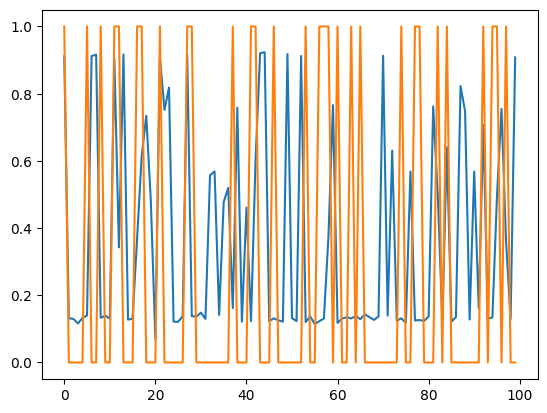

In [30]:
plt.plot(Y_pred[:100], label='pred')
plt.plot(Y_test[:100], label='actual')

In [ ]:
N = 1000  # Define the number of previous observations included

X = df.drop(columns=columns_to_drop).iloc[:len(df)]
Y = df[['time_' + col for col in columns if 'ask_prices_0' in col]].iloc[N:len(df)].values

print(Y.shape)

tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

X_np = X.numpy()

# Now use train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y, test_size=0.8,
                                                    shuffle=True) # just to make test training
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

(101086, 1)


In [ ]:
# Optuna objective function
input_shape = (N+1, 23)

def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])
    filters = trial.suggest_categorical('filters', [16, 32])
    units = trial.suggest_categorical('units', [64, 128])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [64, 128])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [3, 9])
    dilation_rate = trial.suggest_categorical('dilation_rate', [2, 3, 16])
    batch = trial.suggest_categorical('batch', [16,64])

    # Create the model
    model_1000 = create_full_model(input_shape, filters, num_heads, units, 
                              kernel_size_Q, kernel_size_K, kernel_size_V, dilation_rate)
    model_1000.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[#tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc')])
    
    print(filters, num_heads, d_model, units, kernel_size_Q, kernel_size_K, kernel_size_V)
    
    # Train the model with a validation set
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    
    history = model_1000.fit(x=X_train, y=Y_train, 
              batch_size=batch, 
              epochs=10, 
              callbacks=[callback],
              class_weight=class_weights_dict,
              validation_data=(X_val, Y_val)) # Include validation data here

    val_loss = np.mean(history.history['val_auc']) + np.mean(history.history['auc'])
    
    return val_loss

# Optuna study
study = optuna.create_study(direction='maximize')  # 'minimize' if lower is better, 'maximize' otherwise
study.optimize(objective, n_trials=10)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Define model parameters
output_shape = 1
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size_Q = trial.params['kernel_size_Q']
kernel_size_K = trial.params['kernel_size_K']
kernel_size_V = trial.params['kernel_size_V']
batch = trial.params['batch']
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, units, 
                              kernel_size_Q, kernel_size_K, kernel_size_V)

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Train the model with a validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(x=X_train, y=Y_train, 
          batch_size=batch, 
          epochs=100, 
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_val, Y_val))

Y_pred = model.predict(X_test)

In [ ]:
plt.plot(Y_pred, label='pred')
plt.plot(Y_test, label='actual')

# Try toy model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

In [ ]:
toy_model = Sequential()

# Using LSTM for sequential data
toy_model.add(LSTM(64, return_sequences=True, input_shape=input_shape))

toy_model.add(LSTM(32, return_sequences=True))

# SeqSelfAttention layer
toy_model.add(SeqSelfAttention(units=1, attention_activation='sigmoid', 
                               attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))

# Flatten the output to feed into a Dense layer
toy_model.add(Flatten())

# Dense layer(s) and Output layer
toy_model.add(Dense(64, activation='relu'))
toy_model.add(Dense(1, activation='sigmoid'))

# Compile the model
toy_model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[#CategoricalAccuracy(), 
                           Precision(), 
                           Recall(), 
                           AUC()])

# Model summary
toy_model.summary()

history = toy_model.fit(x=X_train, y=Y_train, 
          batch_size=batch, 
          epochs=100, 
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_val, Y_val))

In [ ]:
Y_toy_pred = toy_model.predict(X_test)
plt.plot(Y_toy_pred, label='predicted')
plt.plot(Y_test, label='actual')
plt.legend()

# Baseline model

In [ ]:
X = X.reshape(len(X), -1)  # This will reshape X to (len(X), (N+1)*23)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Create a logistic regression model
model_base = LogisticRegression()

# Train the model
model_base.fit(X_train, Y_train.ravel())

# Make predictions
Y_base_pred = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(Y_test, Y_base_pred)
print(f"Model AUC Score: {auc_score}")

In [ ]:
plt.plot(Y_base_pred, label='predicted')
plt.plot(Y_test, label='actual')
plt.legend()

In [ ]:
auc_score_trans = roc_auc_score(Y_test, Y_pred)
auc_score_toy = roc_auc_score(Y_test, Y_toy_pred)
auc_score_base = roc_auc_score(Y_test, Y_base_pred)
print(f"Transformer Model AUC Score: {auc_score_trans}")
print(f"Toy Model AUC Score: {auc_score_toy}")
print(f"Logistic Regression Model AUC Score: {auc_score_base}")

In [ ]:
explainer = shap.TreeExplainer(toy_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,
    feature_names=X.columns,
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])